In [1]:
import sys

sys.path.append("C:\\Users\\Gabija\\anaconda3\\Lib\\site-packages")
import nb_black

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
from IPython.display import Image

import numpy as np
import pandas as pd
import textwrap

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import f_classif
import scipy.stats as stats
from scipy.stats import shapiro, mannwhitneyu
import myfunctions
from csv import QUOTE_NONNUMERIC, QUOTE_NONE

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None, "display.max_columns", None)
print("Setup complete")

Setup complete


<IPython.core.display.Javascript object>

# Capstone Project "Risk Evaluation as a Service for Retail Banks"

Objectives:<br>
* Practice translating business requirements into data science tasks.<br>
* Practice performing EDA.<br>
* Practice applying statistical inference procedures.<br>
* Practice using machine learning to solve business problems.<br>
* Practice deploying multiple machine learning models.

Requirements:<br>
* Create a plan for your investigation, analysis, and POC building. This should include your assumptions, overall objectives, and objectives for each step in your plan. You are not expected to have a plan for the whole project but instead have a clear understanding of what you'll try to achieve in the next step and build the plan one step at a time.<br>
* Perform exploratory data analysis. This should include creating statistical summaries and charts, testing for anomalies, checking for correlations and other relations between variables, and other EDA elements.<br>
* Perform statistical inference. This should include defining the target population, forming multiple statistical hypotheses and constructing confidence intervals, setting the significance levels, conducting z or t-tests for these hypotheses.<br>
* Use machine learning models to predict the target variables based on your proposed plan. You should use hyperparameter tuning, model ensembling, the analysis of model selection, and other methods. The decision of where to use and not to use these techniques is up to you; however, they should be aligned with your objectives.<br>
* Deploy these machine learning models to Google Cloud Platform. You are free to choose any deployment option you wish as long as it can be called an HTTP request.<br>
* Provide clear explanations in your notebook. Your explanations should inform the reader what you are trying to achieve, what results you got, and what these results mean.<br>
* Provide suggestions about how your analysis and models can be improved.

We need to build the model to predict if applicant will pay back the loan or default.
2 main tables are application_train.csv and application_test.csv, which contain applications of the clients 
who have applied for loan. All the other 6 tables are referenced with this table using the unique ID.

The main objective is to identify the potential Defaulters based on the given data about the applicants.
In further work loans that were payed back are considered as "Good", and defaulting as "Risky".

* Here is the schema for the dataset used for this project:

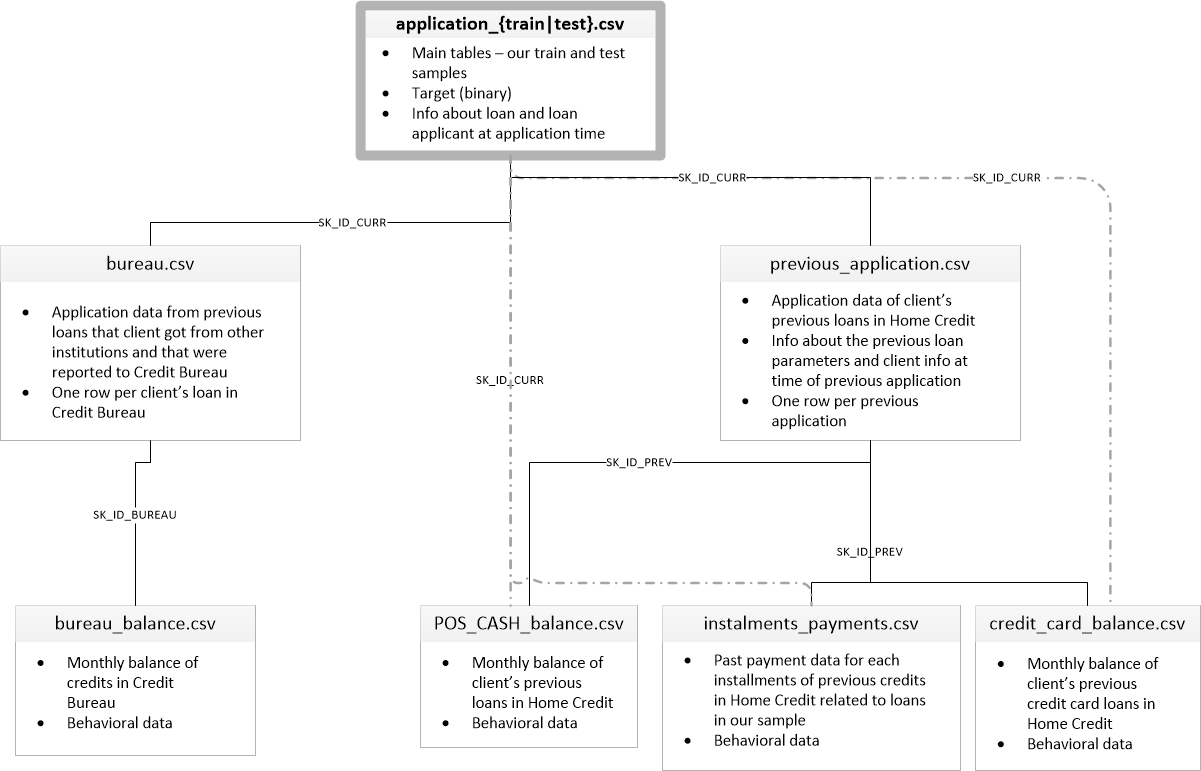

<IPython.core.display.Javascript object>

In [4]:
Image(filename="home_credit.png")

* Description of tables:
    * **application_{train|test}.csv**:<br>
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET). Static data for all applications. One row represents one loan in data sample.<br>
    * **bureau.csv**:<br>
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). For every loan in our sample, there are as many rows as number of credits the
client had in Credit Bureau before the application date.<br>
    * **bureau_balance.csv**:<br>
Monthly balances of previous credits in Credit Bureau. This table has one row for each month of history of every previous credit
reported to Credit Bureau – i.e the table has (#loans in sample * # of relative
previous credits * # of months where we have some history observable for the
previous credits) rows.
    * **POS_CASH_balance.csv**:<br>
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. This table has one row for each month of history of every previous credit in
Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of
months in which we have some history observable for the previous credits) rows.
    * **credit_card_balance.csv**:<br>
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit. This table has one row for each month of history of every previous credit in
Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * #
of months where we have some history observable for the previous credit card) rows.
    * **previous_application.csv**:<br>
All previous applications for Home Credit loans of clients who have loans in our sample. There is one row for each previous application related to loans in our data sample.
    * **installments_payments.csv**: <br>
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. There is a) one row for every payment that was made plus b) one row each for missed payment. One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [4]:
application_train = pd.read_csv("application_train.csv")
application_train = myfunctions.reduce_mem_usage(application_train)
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.0,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,

<IPython.core.display.Javascript object>

In [6]:
application_test = pd.read_csv("application_test.csv")
application_test = myfunctions.reduce_mem_usage(application_test)
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018845,-19241,-2329,-5168.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752441,0.789551,0.159546,0.065979,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.050507,NaN,NaN,0.067200,0.061188,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.052612,NaN,NaN,0.066589,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.051392,NaN,NaN,NaN,block of flats,0.039215,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035797,-18064,-4469,-9120.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564941,0.291748,0.432861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019104,-20038,-4458,-2176.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699707,0.610840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secon

<IPython.core.display.Javascript object>

In [7]:
bureau = pd.read_csv("bureau.csv")
bureau = myfunctions.reduce_mem_usage(bureau)
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


<IPython.core.display.Javascript object>

In [8]:
bureau_credit_balance = pd.read_csv("bureau_balance.csv")
bureau_credit_balance = myfunctions.reduce_mem_usage(bureau_credit_balance)
bureau_credit_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


<IPython.core.display.Javascript object>

In [9]:
pos_cash = pd.read_csv("POS_CASH_balance.csv")
pos_cash = myfunctions.reduce_mem_usage(pos_cash)
pos_cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


<IPython.core.display.Javascript object>

In [10]:
credit_card = pd.read_csv("credit_card_balance.csv")
credit_card = myfunctions.reduce_mem_usage(credit_card)
credit_card.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.0,11925.0,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.0,27000.0,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


<IPython.core.display.Javascript object>

In [11]:
prev_application = pd.read_csv("previous_application.csv")
prev_application = myfunctions.reduce_mem_usage(prev_application)
prev_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [12]:
installments_payments = pd.read_csv("installments_payments.csv")
installments_payments = myfunctions.reduce_mem_usage(installments_payments)
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


<IPython.core.display.Javascript object>

In [23]:
print("Size of application_train table", application_train.shape)
print("Size of bureau table", bureau.shape)
print("Size of bureau_balance table", bureau_credit_balance.shape)
print("Size of POS_CASH_balance table", pos_cash.shape)
print("Size of credit_card_balance table", credit_card.shape)
print("Size of previous_application table", prev_application.shape)
print("Size of installments_payments table", installments_payments.shape)
print("Size of application_test table", application_test.shape)

Size of application_train table (307511, 122)
Size of bureau table (1716428, 17)
Size of bureau_balance table (27299925, 3)
Size of POS_CASH_balance table (10001358, 8)
Size of credit_card_balance table (3840312, 23)
Size of previous_application table (1670214, 37)
Size of installments_payments table (13605401, 8)
Size of application_test table (48744, 121)


<IPython.core.display.Javascript object>

* Here please check the description of all columns in the tables:

In [24]:
columns_description = pd.read_csv(
    "HomeCredit_columns_description.csv",
    encoding="latin-1",
    usecols=["Table", "Row", "Description"],
)
columns_description.style.set_properties(subset=["Description"], **{"width": "1000px"})

,Table,Row,Description
0,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample
1,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,application_{train|test}.csv,CODE_GENDER,Gender of the client
4,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car
5,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has
7,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client
8,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan
9,application_{train|test}.csv,AMT_ANNUITY,Loan annuity


<IPython.core.display.Javascript object>

* The following outcome provides the list of top 5 features with most missing values. only one table "bureau_balance.csv" has no missing values. I will deal with missing values later, when performing statistical inference: 

In [13]:
print(
    "Top 5 missing values in application_train table\n",
    myfunctions.missing_values_summary(application_train).head(),
    "\n" + "*" * 50,
)

print(
    "Top 5 missing values in bureau table\n",
    myfunctions.missing_values_summary(bureau).head(),
    "\n" + "*" * 50,
)
print(
    "Top 5 missing values in bureau_balance table\n",
    myfunctions.missing_values_summary(bureau_credit_balance).head(),
    "\n" + "*" * 50,
)
print(
    "Top 5 missing values in POS_CASH_balance table\n",
    myfunctions.missing_values_summary(pos_cash).head(),
    "\n" + "*" * 50,
)
print(
    "Top 5 missing values in credit_card_balance table\n",
    myfunctions.missing_values_summary(credit_card).head(),
    "\n" + "*" * 50,
)
print(
    "Top 5 missing values in previous_application table\n",
    myfunctions.missing_values_summary(prev_application).head(),
    "\n" + "*" * 50,
)
print(
    "Top 5 missing values in installments_payments table\n",
    myfunctions.missing_values_summary(installments_payments).head(),
    "\n" + "*" * 50,
)
print(
    "Top 5 missing values in application_test table\n",
    myfunctions.missing_values_summary(application_test).head(),
    "\n" + "*" * 50,
)

There are 67 columns that have missing values.
Top 5 missing values in application_train table
                           Missing Values  % of Total Values     type
COMMONAREA_MEDI                   214865            69.8723  float16
COMMONAREA_AVG                    214865            69.8723  float16
COMMONAREA_MODE                   214865            69.8723  float16
NONLIVINGAPARTMENTS_MEDI          213514            69.4330  float16
NONLIVINGAPARTMENTS_MODE          213514            69.4330  float16 
**************************************************
There are 7 columns that have missing values.
Top 5 missing values in bureau table
                         Missing Values  % of Total Values     type
AMT_ANNUITY                    1226791            71.4735  float32
AMT_CREDIT_MAX_OVERDUE         1124488            65.5133  float32
DAYS_ENDDATE_FACT               633653            36.9170  float16
AMT_CREDIT_SUM_LIMIT            591780            34.4774  float32
AMT_CREDIT_SUM_DEBT

<IPython.core.display.Javascript object>

* Focus on the main table for EDA "application_train.csv"

In [6]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.0,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,

<IPython.core.display.Javascript object>

In [7]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float16(61), float32(4), int16(2), int32(2), int8(37), object(16)
memory usage: 92.4+ MB


<IPython.core.display.Javascript object>

In [8]:
application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.0,307511.000000,104582.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.0,306490.0,306490.0,306490.0,307510.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.0,265992.0,265992.0,265992.0,265992.0,265992.0
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990259e+05,27108.572266,5.383961e+05,0.000000,-16036.995067,63815.045904,NaN,-2994.202373,NaN,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,NaN,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,NaN,0.0,NaN,0.00

<IPython.core.display.Javascript object>

In [9]:
application_train["SK_ID_CURR"].duplicated().sum()

0

<IPython.core.display.Javascript object>

In [10]:
myfunctions.single_value_features(application_train)

[]

<IPython.core.display.Javascript object>

* Check mumber of unique classes in each object column:

In [11]:
application_train.select_dtypes("object").apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

<IPython.core.display.Javascript object>

* The dataframe application_train and application_test contains information about the loan and loan applicants. 
The dataframe bureau contains information about the application data from other loans that the client took from other 
credit institutions and were reported to the credit bureau. The dataframe previous_applications contains information about
previous loans at Home Credit by the same client, previous loans information and client information at the time of the loan 
(there is a line in the dataframe per previous loan application).
SK_ID_CURR is connecting the dataframes application_train|test with bureau, previous_application and also with dataframes
POS_CASH_balance, installments_payment and credit_card_balance. SK_ID_PREV connects dataframe previous_application with POS_CASH_balance, 
installments_payment and credit_card_balance. SK_ID_BUREAU connects dataframe bureau with dataframe bureau_balance.
* In the next part EDA we will look at the information in the applicant_train table. The table itself consists of 307511 entries and 122 columns. 67 columns have missing values and no duplicates.

### Number of Applicants in Relation with TARGET as 'Good'(or payed loan) and 'Risky'(or loan that defaulted):

The plot shows that our target('Risky' loans) is only 8.1% of the total, indicating that the data is highly imbalanced.

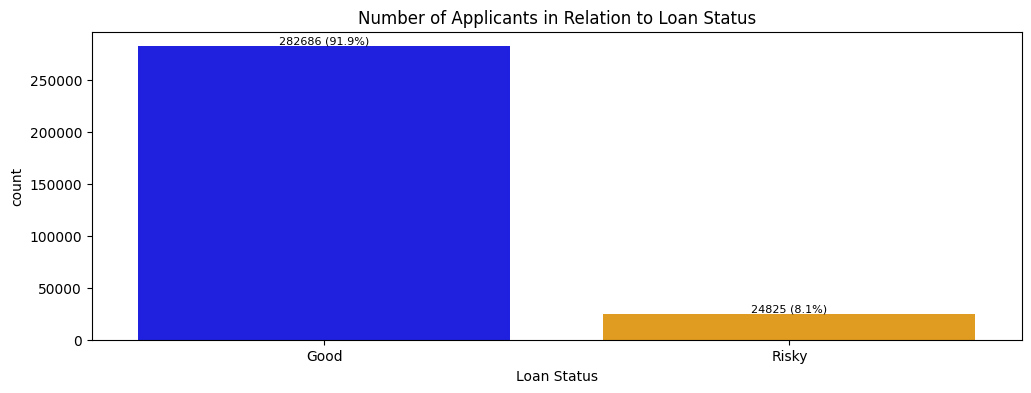

<IPython.core.display.Javascript object>

In [5]:
plt.figure(figsize=(12, 4))
custom_palette = {"0": "blue", "1": "orange"}
bars = sns.countplot(x="TARGET", data=application_train, palette=custom_palette)

total = float(len(application_train))
for bar in bars.patches:
    height = bar.get_height()
    percentage = (height / total) * 100
    plt.annotate(
        f"{int(height)} ({percentage:.1f}%)",
        (bar.get_x() + bar.get_width() / 2, height + 10),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.title("Number of Applicants in Relation to Loan Status")
plt.xlabel("Loan Status")
plt.xticks([0, 1], ["Good", "Risky"])
plt.show()

### Distribution of loan Status by loan Type:

* Cash loans mean usually a short-term high interest loans;
* Revolving loan provides a borrower with a maximum aggregate amount of capital, available over a specified period of time.<br>

Compared with revolving type loans  cash 

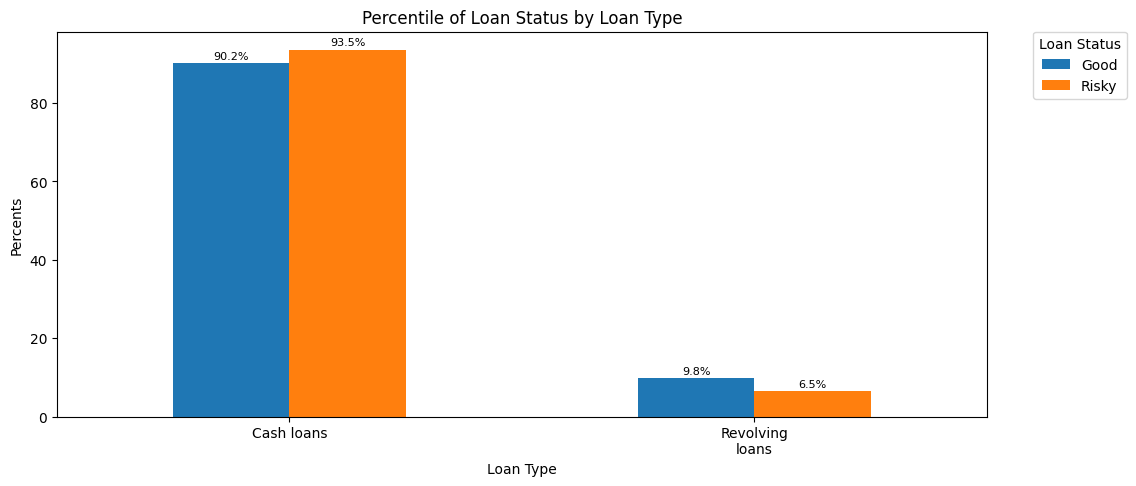

<IPython.core.display.Javascript object>

In [6]:
myfunctions.plot_percentile_by_column(
    application_train,
    "NAME_CONTRACT_TYPE",
    "Loan Type",
    "Percentile of Loan Status by Loan Type",
)

### Distribution of Clients Age:

* For this part I created a new feature "AGE_YEAR" that transforms age from days to years and groups customers in certain age groups for better visualization. 
* The youngest client is of 20.5 years old and oldest - 69 years old.
* The largest group of customers is 31-40 years old (27% of all existing customers), the smallest group is 61-70 years old (12% of all existing customers).


The age range in dataset:  20.517808219178082 - 69.12054794520547 years


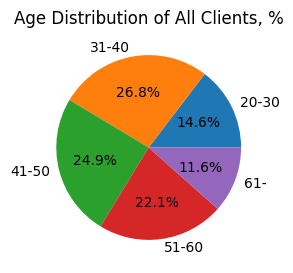

<IPython.core.display.Javascript object>

In [7]:
age_bins = [20, 30, 40, 50, 60, 70]
age_labels = ["20-30", "31-40", "41-50", "51-60", "61-"]
application_train = myfunctions.make_age(application_train)

print(
    "The age range in dataset: ",
    application_train["AGE_YEAR"].min(),
    "-",
    application_train["AGE_YEAR"].max(),
    "years",
)

age_hist, _ = np.histogram(application_train["AGE_YEAR"], bins=age_bins)


fig, ax = plt.subplots(figsize=(4, 3))
ax.pie(age_hist, labels=age_labels, autopct="%1.1f%%")
plt.title("Age Distribution of All Clients, %")
plt.show()

* If we consider all outstanding loans from the point of view of the age group, we would consider the 31-40 age group to be the riskiest (31% of all outstanding loans), followed by the 20-30 age group (21%). The age group 61-70 is the least risky (7% of all outstanding loans).

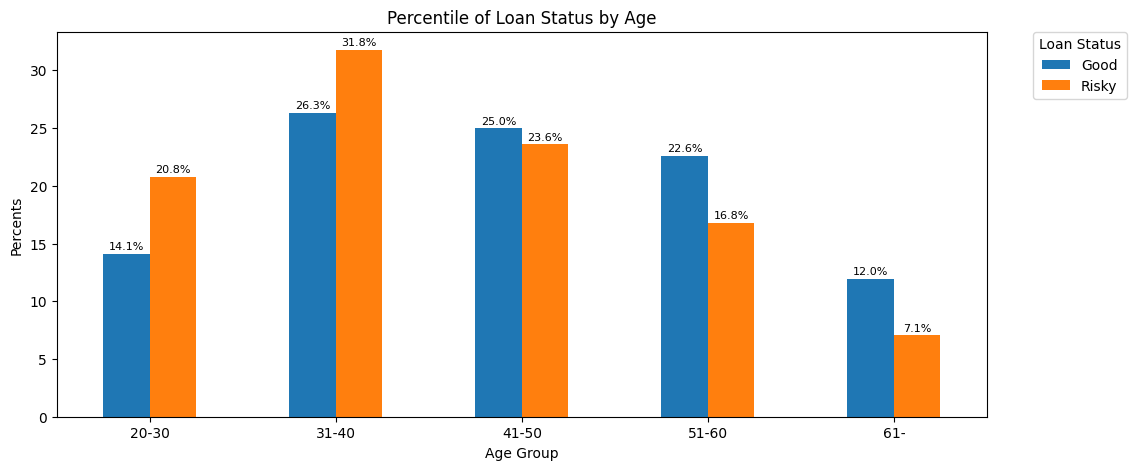

<IPython.core.display.Javascript object>

In [8]:
myfunctions.plot_percentile_by_column(
    application_train,
    "AGE_BINS",
    "Age Group",
    "Percentile of Loan Status by Age",
)

### Distribution of Loan Status by Gender:

* F means female;
* M means male;
* XNA means undefined gender.

The plot shows, that from all loans female custommers tends to be riskier since their defaulted loan quantity is 57% compared to male customers(43%). Gender "XNA" is not definied and it will not be useful, therefore I will delete 4 entries from dataset.

In [9]:
application_train["CODE_GENDER"].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

<IPython.core.display.Javascript object>

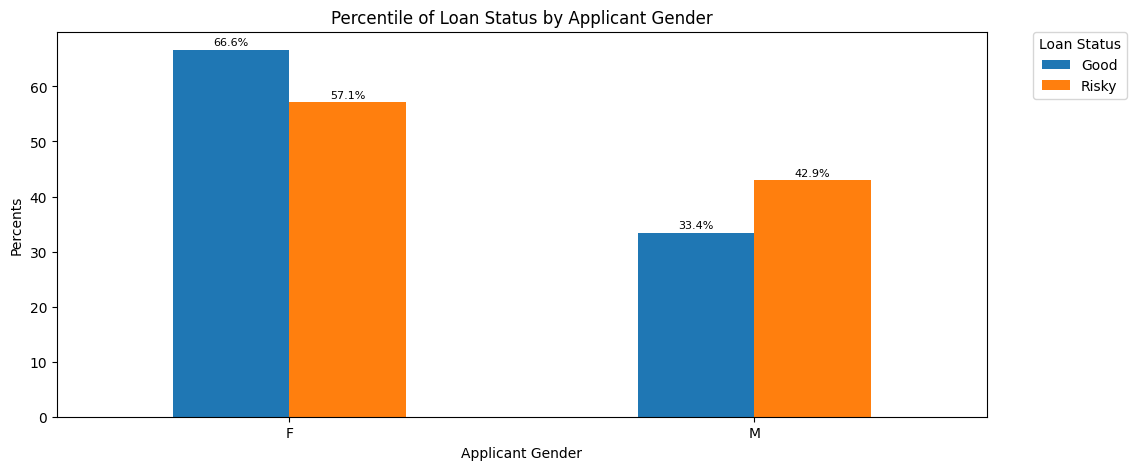

<IPython.core.display.Javascript object>

In [10]:
application_train = myfunctions.delete_gender(application_train)

myfunctions.plot_percentile_by_column(
    application_train,
    "CODE_GENDER",
    "Applicant Gender",
    "Percentile of Loan Status by Applicant Gender",
)

### Distribution of Loan Status in Relation with Customer's Family Status:

* The most at-risk to default groups are those who are in civil marriage (9.9%) or single people (9.8%). The lowest risk group is the widowed people (5.8%).

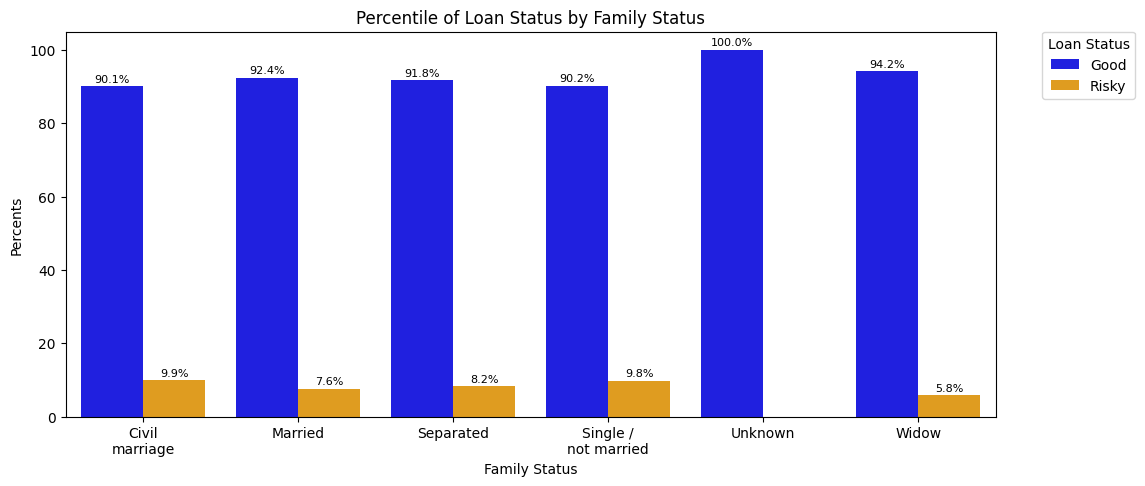

<IPython.core.display.Javascript object>

In [11]:
myfunctions.plot_percentile_for_each_group_by_column(
    application_train,
    "NAME_FAMILY_STATUS",
    "Family Status",
    "Percentile of Loan Status by Family Status",
)

### Distribution of Loan Status in Relation of Client's Family Size:

* The risk of a loan default increases significantly in a family of 6 or more persons (13.5% of the outstanding loans in this group), but we cannot analyse in more detail for a larger number of persons, as there is insufficient data available. The lowest risk is in a family of 2 persons (7.6% of defaulted loans).

In [12]:
application_train["CNT_FAM_MEMBERS"].value_counts()

CNT_FAM_MEMBERS
2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
12.0         2
20.0         2
16.0         2
13.0         1
15.0         1
11.0         1
Name: count, dtype: int64

<IPython.core.display.Javascript object>

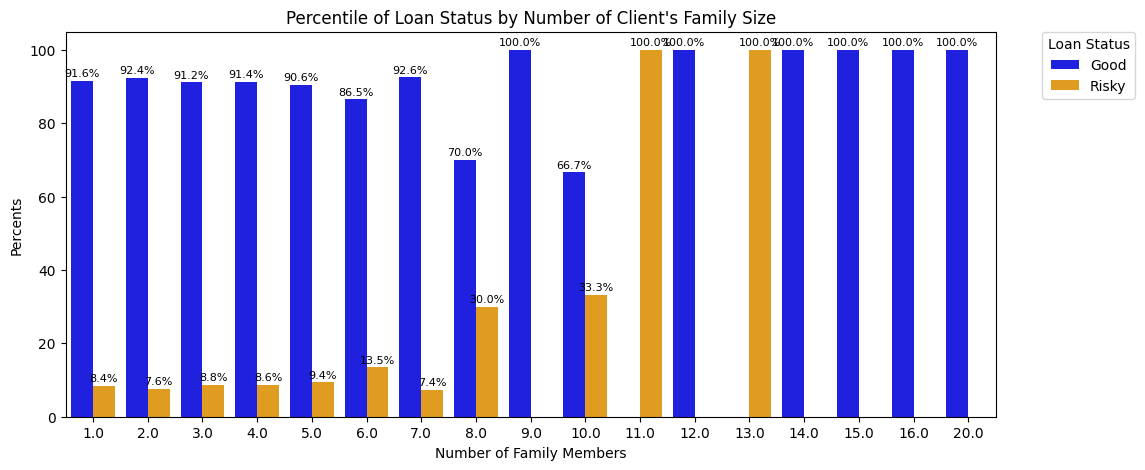

<IPython.core.display.Javascript object>

In [13]:
application_train["CNT_FAM_MEMBERS"] = application_train["CNT_FAM_MEMBERS"].astype(
    "float32"
)

myfunctions.plot_percentile_for_each_group_by_column(
    application_train,
    "CNT_FAM_MEMBERS",
    "Number of Family Members",
    "Percentile of Loan Status by Number of Client's Family Size",
)

### Distribution of Loan Status in Relation with Number of Children Custommer Has:

The risk increases dramatically when the family size is 6. However, the data for clients with more children are not equally distributed: the number of such clients is simply too small. 

Number of children the customer has:
 CNT_CHILDREN
0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
8          2
9          2
10         2
11         1
12         2
14         3
19         2
Name: count, dtype: int64


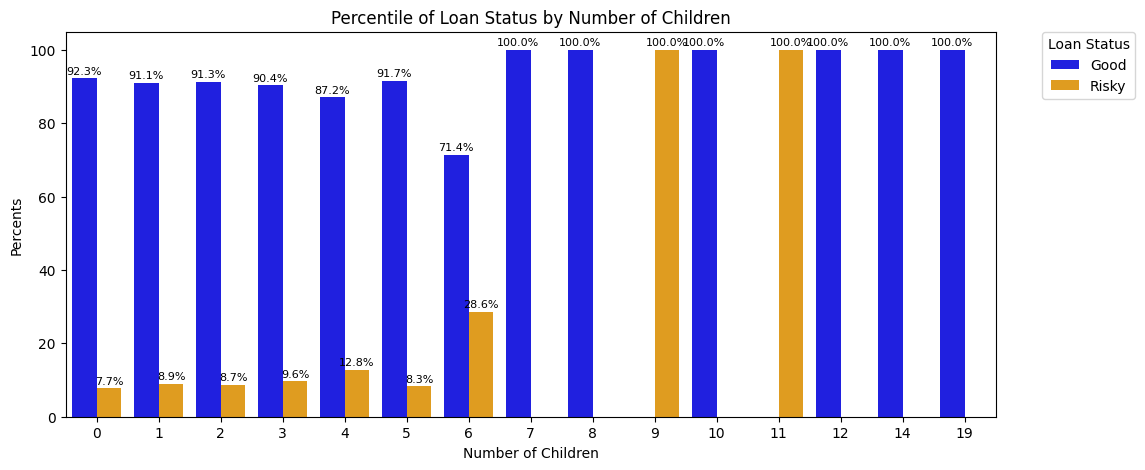

<IPython.core.display.Javascript object>

In [14]:
print(
    "Number of children the customer has:\n",
    application_train["CNT_CHILDREN"].value_counts().sort_index(),
)
myfunctions.plot_percentile_for_each_group_by_column(
    application_train,
    "CNT_CHILDREN",
    "Number of Children",
    "Percentile of Loan Status by Number of Children",
)

### Distribution of Loan Status in Relation with Customer's Education Type:

* The riskier group is cutomers that have lower than secondary school education (11%). In contrast people with academic degree are least risky group (2% that tend to default).

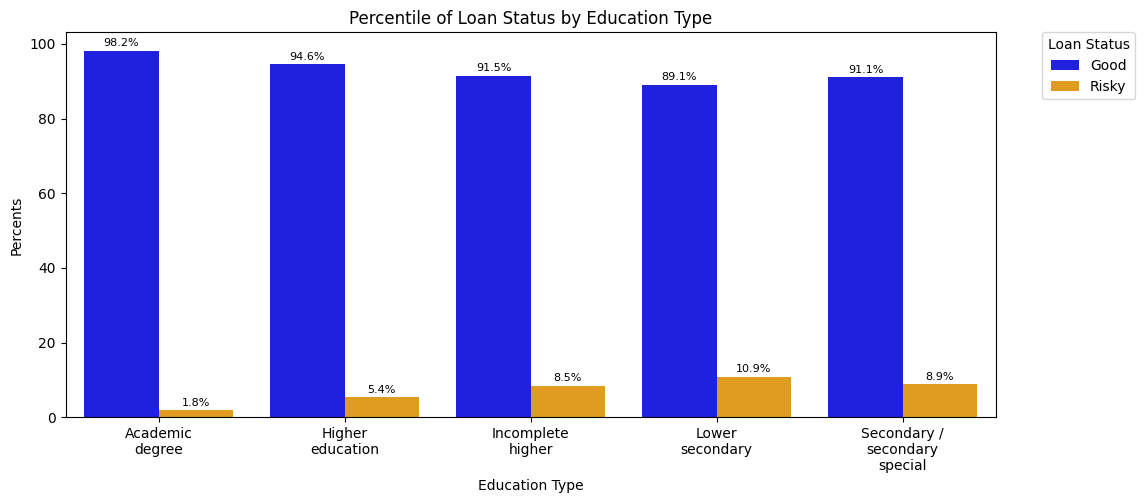

<IPython.core.display.Javascript object>

In [15]:
myfunctions.plot_percentile_for_each_group_by_column(
    application_train,
    "NAME_EDUCATION_TYPE",
    "Education Type",
    "Percentile of Loan Status by Education Type",
)

### Distribution of Loan Status in Relation with Income Type:

The riskiest group is the person on maternity leave and the unemployed. The least risky are entrepreneurs and students.

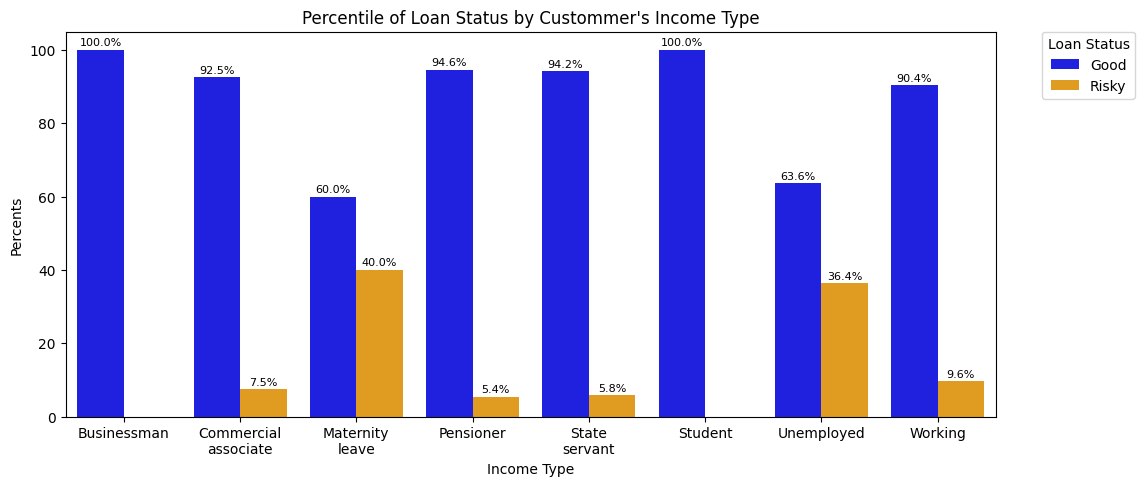

<IPython.core.display.Javascript object>

In [16]:
myfunctions.plot_percentile_for_each_group_by_column(
    application_train,
    "NAME_INCOME_TYPE",
    "Income Type",
    "Percentile of Loan Status by Custommer's Income Type",
)

### Distribution of loan Status by Vehicle Ownership:

* N means No ownership;
* Y means applicant owns car.

Customers that do not own vehicle should be considered as riskier (69.5%) of all defaulted loans.

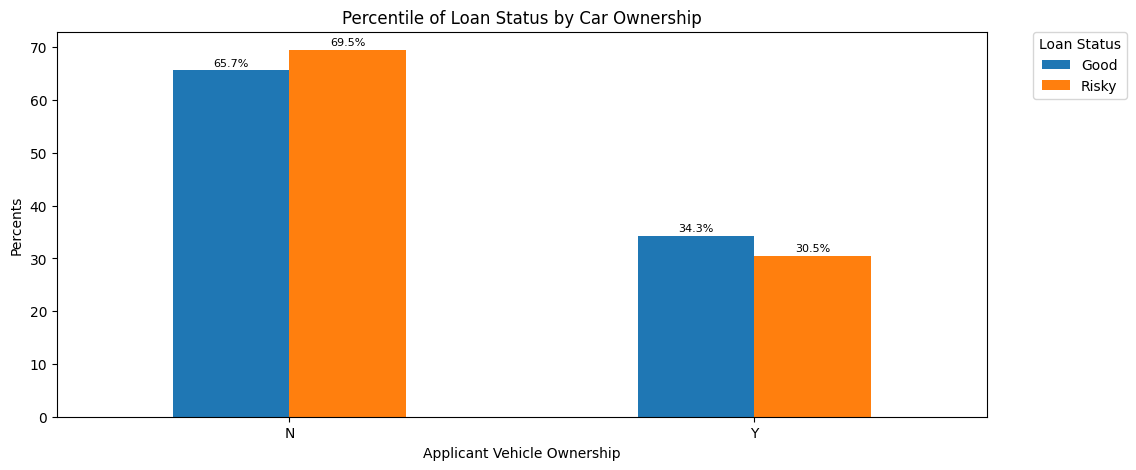

<IPython.core.display.Javascript object>

In [17]:
myfunctions.plot_percentile_by_column(
    application_train,
    "FLAG_OWN_CAR",
    "Applicant Vehicle Ownership",
    "Percentile of Loan Status by Car Ownership",
)

### Applicant Ownership of Real Estate:

* N means No ownership;
* Y means applicant owns real estate.

When comparing property owners with non-owners, the later are a little riskier clients, but in general percentage is about the same.

In [25]:
application_train.groupby("TARGET")["FLAG_OWN_REALTY"].value_counts()

TARGET  FLAG_OWN_REALTY
0       Y                  196329
        N                   86357
1       Y                   16983
        N                    7842
Name: count, dtype: int64

<IPython.core.display.Javascript object>

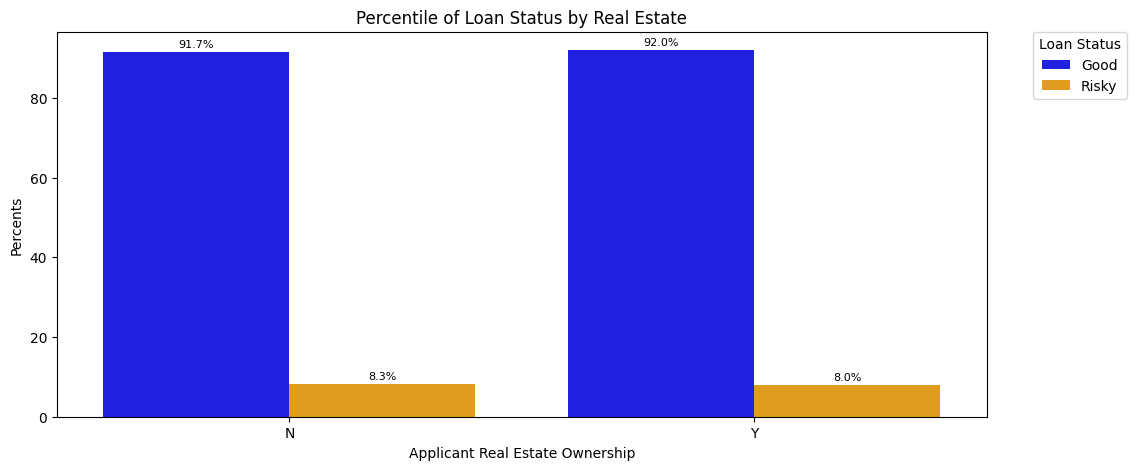

<IPython.core.display.Javascript object>

In [18]:
myfunctions.plot_percentile_for_each_group_by_column(
    application_train,
    "FLAG_OWN_REALTY",
    "Applicant Real Estate Ownership",
    "Percentile of Loan Status by Real Estate",
)

### Distribution of Loan Status in Relation with Customer's Housing Type:

* In terms of housing type, the most risky group is those renting (12.3%), followed by those living with their parents (11.7% of outstanding loans).

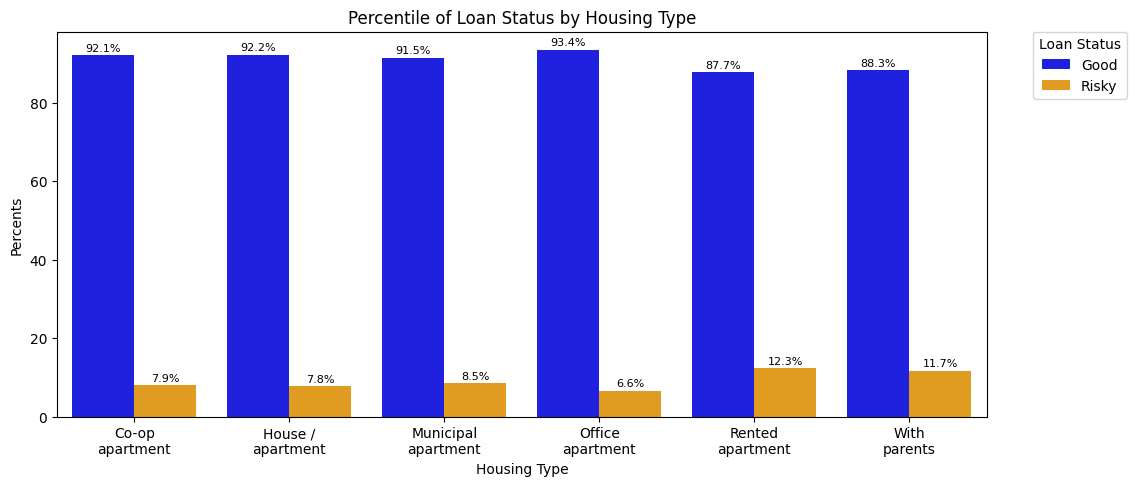

<IPython.core.display.Javascript object>

In [19]:
myfunctions.plot_percentile_for_each_group_by_column(
    application_train,
    "NAME_HOUSING_TYPE",
    "Housing Type",
    "Percentile of Loan Status by Housing Type",
)

### Distribution of Loan Status in Relation of Client's Region Population:

* This column measures the population density of the client's residential area, a higher number indicates a higher population density and conversely a lower number indicates a less populated area.
* In this case, the riskiest group is in a sparsely populated area

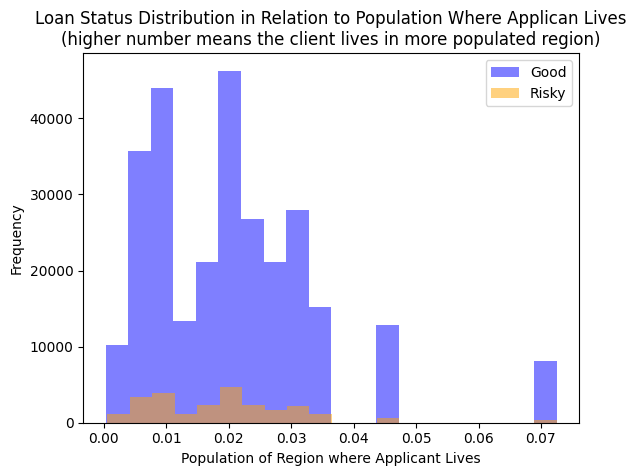

<IPython.core.display.Javascript object>

In [20]:
df_target_0 = application_train[application_train["TARGET"] == 0]
df_target_1 = application_train[application_train["TARGET"] == 1]

plt.hist(
    df_target_0["REGION_POPULATION_RELATIVE"],
    bins=20,
    alpha=0.5,
    color="blue",
    label="Good",
)
plt.hist(
    df_target_1["REGION_POPULATION_RELATIVE"],
    bins=20,
    alpha=0.5,
    color="orange",
    label="Risky",
)

plt.xlabel("Population of Region where Applicant Lives")
plt.ylabel("Frequency")
plt.title(
    "Loan Status Distribution in Relation to Population Where Applican Lives\n(higher number means the client lives in more populated region)"
)
plt.legend()
plt.show()

### Distribution of Loan Status in Relation of Client's Occupation Type:

* The riskiest group is Low-skill laborers (17.2%), followed by drivers and catering staff (each 11.3%);
* The least risky are accountants (4.8%).

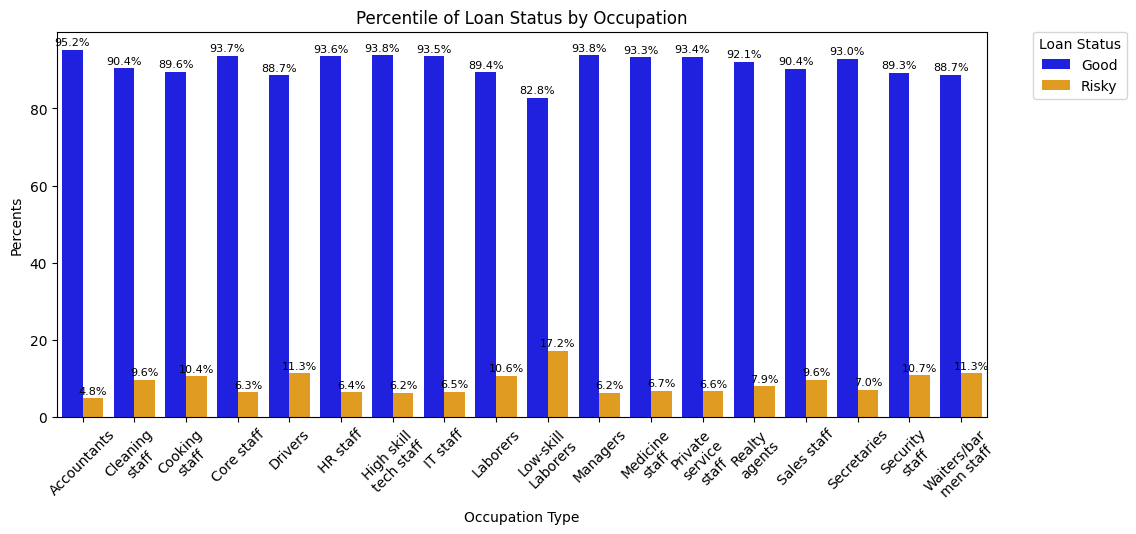

<IPython.core.display.Javascript object>

In [21]:
myfunctions.plot_percentile_for_each_group_by_column(
    application_train,
    "OCCUPATION_TYPE",
    "Occupation Type",
    "Percentile of Loan Status by Occupation",
    x_label_rotation=45,
)

### Distribution of the Loan Status by Employment Term:

* For this part I calculate and add new feature "EMPLOY_YEAR" that changes days of employment to years for better visualization.
* This group has annomaly as 365243 days of employment. In this case I will change it into null value.
* The general trend shows that the riskiest group is those with no work experience or with less than 1 year of work experience. And increasing work experience shows that the risk of default is decreasing. The least risky group is the group with 41-50 years of experience, which is increasing again, as I guess, due to natural mortality reasons.

The employment years range in dataset:  0.0 - 49.07397260273972 years


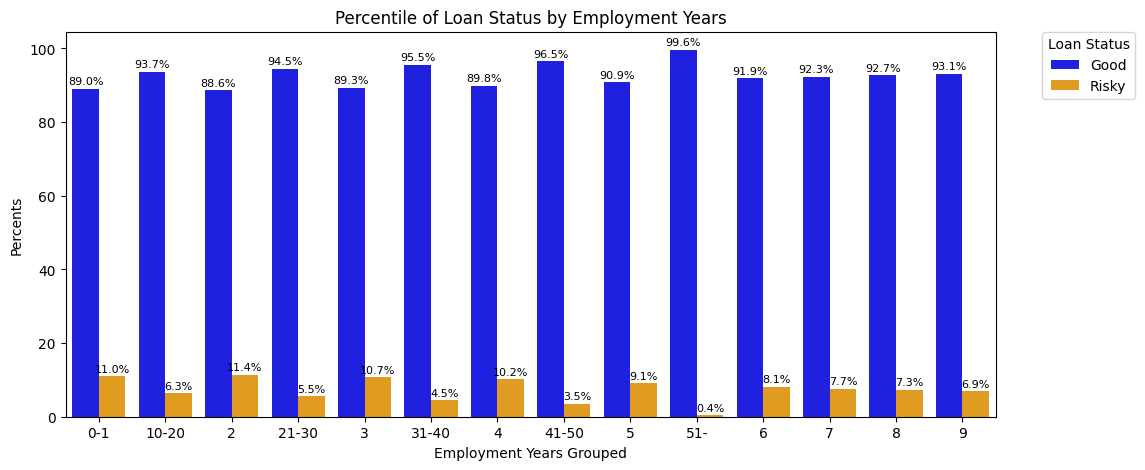

<IPython.core.display.Javascript object>

In [22]:
employ_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50]
employ_labels = [
    "0-1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "10-20",
    "21-30",
    "31-40",
    "41-50",
    "51-",
]

application_train = myfunctions.replace_employ_annomaly(application_train)
application_train = myfunctions.make_employ(application_train)

print(
    "The employment years range in dataset: ",
    application_train["EMPLOY_YEAR"].min(),
    "-",
    application_train["EMPLOY_YEAR"].max(),
    "years",
)
myfunctions.plot_percentile_for_each_group_by_column(
    application_train,
    "EMPLOY_BINS",
    "Employment Years Grouped",
    "Percentile of Loan Status by Employment Years",
)

### Distribution of Loan Status in Relation to Annual Income:

* As the column "Annual income" has a very large number of variables, I have created an additional column "Annual income per family member" for better display.
The graph clearly shows that as the number of family members increases, the average annual income decreases. However, in our case, it is interesting to note that the riskiest position is when the number of family members is higher than 6. Also, the trend between annual income, family size and insolvency occurs in a family of 3 persons.

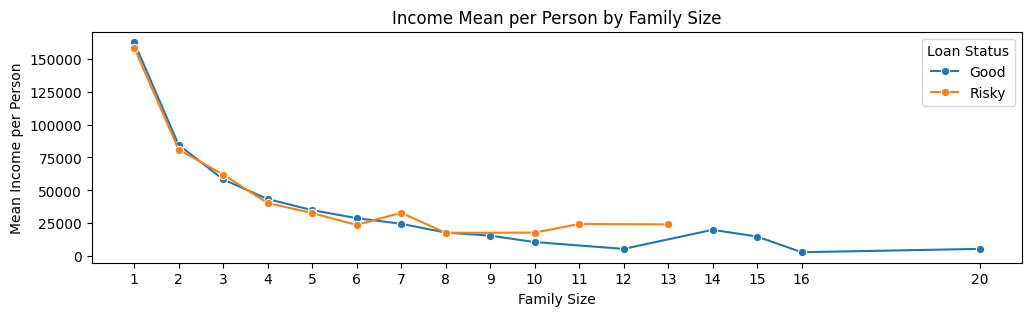

<IPython.core.display.Javascript object>

In [23]:
application_train["CNT_FAM_MEMBERS"] = application_train["CNT_FAM_MEMBERS"].astype(
    "float32"
)
application_train = myfunctions.create_income_family(application_train)
mean_income_by_family_members = application_train.groupby("CNT_FAM_MEMBERS")[
    "ANNUAL_INCOME_PER_FAM"
].mean()

# plot the distribution of Loan status in Relation with annual income per family size:
plt.figure(figsize=(12, 3))

sns.lineplot(
    data=application_train,
    x="CNT_FAM_MEMBERS",
    y="ANNUAL_INCOME_PER_FAM",
    hue="TARGET",
    marker="o",
    linestyle="-",
    ci=None,
)
x_labels = [
    1.0,
    2.0,
    3.0,
    4.0,
    5.0,
    6.0,
    7.0,
    8.0,
    9.0,
    10.0,
    11.0,
    12.0,
    13.0,
    14.0,
    15.0,
    16.0,
    20.0,
]
plt.title("Income Mean per Person by Family Size")
plt.xticks(x_labels)
plt.xlabel("Family Size")
plt.ylabel("Mean Income per Person")
plt.legend(title="Loan Status", labels=["Good", "Risky"])
plt.show()

### Distribution of the Loan Status in Realation with Credit Term:



* To calculate the period (in months) for which the customer took out the loan I had to calculate : AMT_CREDIT (total loan amount) divided by AMT_ANNUITY (it was done via function 'make_feature' 

* Shortest loan term:  8 months;
* Longest loan term:  45  months;
* Most of the loans have been granted for 20 months. The risk decreases as the loan term increases. 

Shortest loan term:  8.0  months
Longest loan term:  45.0  months


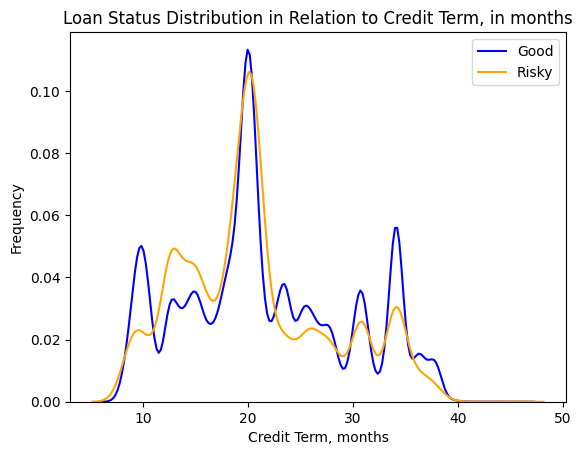

<IPython.core.display.Javascript object>

In [24]:
application_train = myfunctions.create_credit_term(application_train)
print(
    "Shortest loan term: ", round(application_train["CREDIT_TERM"].min(), 0), " months"
)
print(
    "Longest loan term: ", round(application_train["CREDIT_TERM"].max(), 0), " months"
)

myfunctions.plot_kde_for_target_variable(
    application_train,
    "CREDIT_TERM",
    "Credit Term, months",
    "Loan Status Distribution in Relation to Credit Term, in months",
)

### Distribution of Loan Status in Relation of Credit Ammount:

* The vast majority of credits are less than one million USD, which can be explained by the fact that HC lends for short periods of time, while larger credits are considered on a personal basis and evaluated individually (as far as the information found on the practice shows). From the graph we can see that the highest risk is for credits below 250k$.

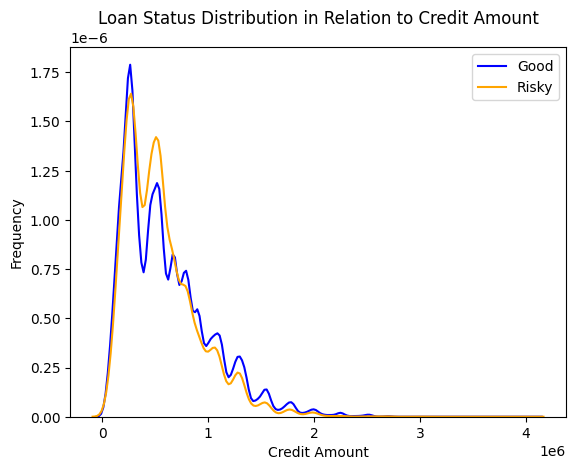

<IPython.core.display.Javascript object>

In [25]:
myfunctions.plot_kde_for_target_variable(
    application_train,
    "AMT_CREDIT",
    "Credit Amount",
    "Loan Status Distribution in Relation to Credit Amount",
)

### Statistical Inference

* For this part I need to filter numeric and categorical features;
* Deal with missing values: I will delete features that have more than 50% missing values and impute using SimpleImputer the mode and median;
* Deal with outliers: I will replace outliers with upper and lower bound detecting them using IQR.

In [26]:
myfunctions.missing_values_summary(application_train)

There are 73 columns that have missing values.


,Missing Values,% of Total Values,type
COMMONAREA_MODE,214865,69.8723,float16
COMMONAREA_MEDI,214865,69.8723,float16
COMMONAREA_AVG,214865,69.8723,float16
NONLIVINGAPARTMENTS_MODE,213514,69.4330,float16
NONLIVINGAPARTMENTS_MEDI,213514,69.4330,float16
NONLIVINGAPARTMENTS_AVG,213514,69.4330,float16
FONDKAPREMONT_MODE,210295,68.3862,object
LIVINGAPARTMENTS_MODE,210199,68.3550,float16
LIVINGAPARTMENTS_AVG,210199,68.3550,float16
LIVINGAPARTMENTS_MEDI,210199,68.3550,float16


<IPython.core.display.Javascript object>

In [27]:
# dropping columns with more than 50% missing values:
myfunctions.delete_missing_values(application_train)

<IPython.core.display.Javascript object>

In [11]:
# filtering numeric and categorical features:
num_features = [
    col
    for col in application_train.select_dtypes(exclude=["object"]).columns
    if col not in ["SK_ID_CURR", "TARGET"]
]
cat_features = [
    col for col in application_train.select_dtypes(include=["object"]).columns
]

<IPython.core.display.Javascript object>

In [29]:
# Using SimpleImputer to imputate remaining missing values with mode, and median:
categorical_imputer = SimpleImputer(strategy="most_frequent")
categorical_imputer.fit(application_train[cat_features])
application_train[cat_features] = categorical_imputer.transform(
    application_train[cat_features]
)

<IPython.core.display.Javascript object>

In [30]:
numeric_imputer = SimpleImputer(strategy="median")
numeric_imputer.fit(application_train[num_features])
application_train[num_features] = numeric_imputer.transform(
    application_train[num_features]
)

<IPython.core.display.Javascript object>

In [31]:
# replacing outliers:
application_train = myfunctions.replace_outliers_with_iqr(application_train)

<IPython.core.display.Javascript object>

* showing feature correlation:

In [32]:
myfunctions.feature_correlation(application_train)

,variable,pearson_corr,F,p_value
0,EXT_SOURCE_2,-0.160294,8109.575982,0.000000e+00
1,EXT_SOURCE_3,-0.155899,7660.045113,0.000000e+00
2,AGE_YEAR,-0.078239,1893.976087,0.000000e+00
3,DAYS_BIRTH,0.078239,1893.976087,0.000000e+00
4,DAYS_EMPLOYED,0.063368,1239.785557,4.797587e-271
5,EMPLOY_YEAR,-0.063368,1239.785557,4.797587e-271
6,REGION_RATING_CLIENT_W_CITY,0.060893,1144.461405,2.078455e-250
7,REGION_RATING_CLIENT,0.058899,1070.491250,2.172433e-234
8,DAYS_LAST_PHONE_CHANGE,0.055219,940.488823,3.181107e-206
9,DAYS_ID_PUBLISH,0.051457,816.396507,2.527524e-179


<IPython.core.display.Javascript object>

Explaining correlation table:
* The pearson_corr coefficient measures the linear relationship between two variables (certtain feature and target), ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation).
* F column contains the F-statistic, which is used in the analysis of variance (ANOVA). In the context of correlation, the F-statistic helps determine whether the correlation between a variable and the target is statistically significant. Higher F-values indicate more statistically significant correlations.
* The p-value represents the probability that the observed correlation occurred by chance. A small p-value (typically less than 0.05) suggests that the correlation is statistically significant.<br>
EXT_SOURCE_2 and EXT_SOURCE_3: These two variables have a strong negative correlation with the target variable (TARGET). The negative correlation suggests that as the values of these variables increase, the likelihood of a positive outcome (or "1" in the target variable) decreases. The very low p-values (close to zero) indicate that these correlations are highly statistically significant.<br>
FLAG_DOCUMENT_5, FLAG_DOCUMENT_20, FLAG_DOCUMENT_12, FLAG_MOBIL, etc.: These variables have very low correlation values (close to zero), and their p-values are also high (close to 1). This suggests that there is little to no correlation between these variables and the target variable.

** **Hypothesis** : credit amount is not statistically significant between charged off and fully payed groups;<br>
** **Alternative** there is significant difference

In [33]:
df_target_0 = application_train[application_train["TARGET"] == 0]
df_target_1 = application_train[application_train["TARGET"] == 1]

<IPython.core.display.Javascript object>

Test Statistic: 0.9057807922363281
P-value: 0.0
The data does not follow a normal distribution (reject the null hypothesis).


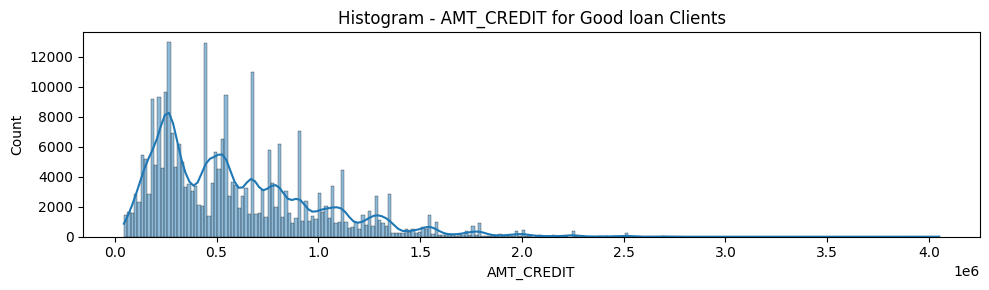

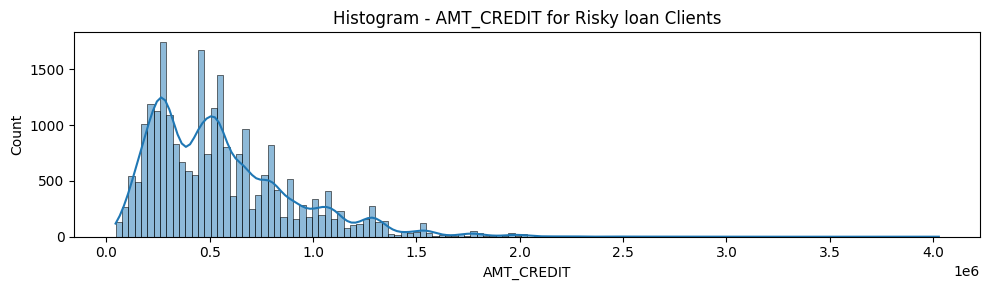

P-value: 2.36018881652632e-22
There is a statistically significant difference between the groups.
The difference between groups in AMT_CREDIT mean: 44869.75
Good loans:
95.0% Confidence Interval for AMT_CREDIT mean: [601148.48, 604148.08]
Risky loans:
95.0% Confidence Interval for AMT_CREDIT mean: [553468.99, 562088.07]


<IPython.core.display.Javascript object>

In [34]:
myfunctions.data_normality_check(application_train, "AMT_CREDIT")
myfunctions.plot_hist(df_target_0, "AMT_CREDIT", "Good loan")
myfunctions.plot_hist(df_target_1, "AMT_CREDIT", "Risky loan")
myfunctions.statistical_significance(
    df_target_0["AMT_CREDIT"], df_target_1["AMT_CREDIT"]
)
myfunctions.mean_difference(df_target_0["AMT_CREDIT"], df_target_1["AMT_CREDIT"])
print("Good loans:")
myfunctions.confidence_interval(df_target_0, "AMT_CREDIT")
print("Risky loans:")
myfunctions.confidence_interval(df_target_1, "AMT_CREDIT")

** **Hypothesis** : annual income per family member amount is not statistically significant between payed off credits and defaulted groups;<br>
** **Alternative** there is significant difference:

Test Statistic: 0.3685586452484131
P-value: 0.0
The data does not follow a normal distribution (reject the null hypothesis).


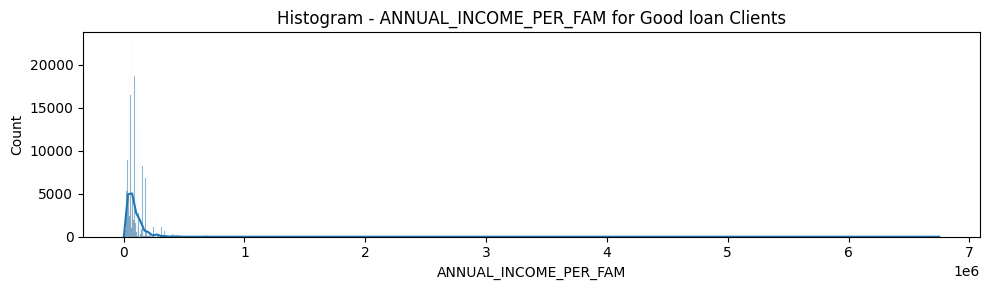

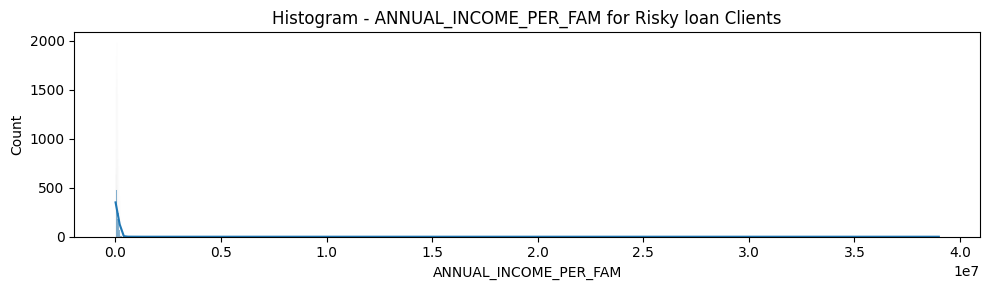

P-value: 3.497957392022484e-20
There is a statistically significant difference between the groups.
The difference between groups in ANNUAL_INCOME_PER_FAM mean: 2445.21
Good loans:
95.0% Confidence Interval for ANNUAL_INCOME_PER_FAM mean: [93030.97, 93575.36]
Risky loans:
95.0% Confidence Interval for ANNUAL_INCOME_PER_FAM mean: [87681.28, 94034.62]


<IPython.core.display.Javascript object>

In [35]:
myfunctions.data_normality_check(application_train, "ANNUAL_INCOME_PER_FAM")
myfunctions.plot_hist(df_target_0, "ANNUAL_INCOME_PER_FAM", "Good loan")
myfunctions.plot_hist(df_target_1, "ANNUAL_INCOME_PER_FAM", "Risky loan")
myfunctions.statistical_significance(
    df_target_0["ANNUAL_INCOME_PER_FAM"], df_target_1["ANNUAL_INCOME_PER_FAM"]
)
myfunctions.mean_difference(
    df_target_0["ANNUAL_INCOME_PER_FAM"], df_target_1["ANNUAL_INCOME_PER_FAM"]
)
print("Good loans:")
myfunctions.confidence_interval(df_target_0, "ANNUAL_INCOME_PER_FAM")
print("Risky loans:")
myfunctions.confidence_interval(df_target_1, "ANNUAL_INCOME_PER_FAM")

** **Hypothesis** : goods price amount is not statistically significant between payed off credits and defaulted groups;<br>
** **Alternative** there is significant difference:

Test Statistic: 0.7680506706237793
P-value: 0.0
The data does not follow a normal distribution (reject the null hypothesis).


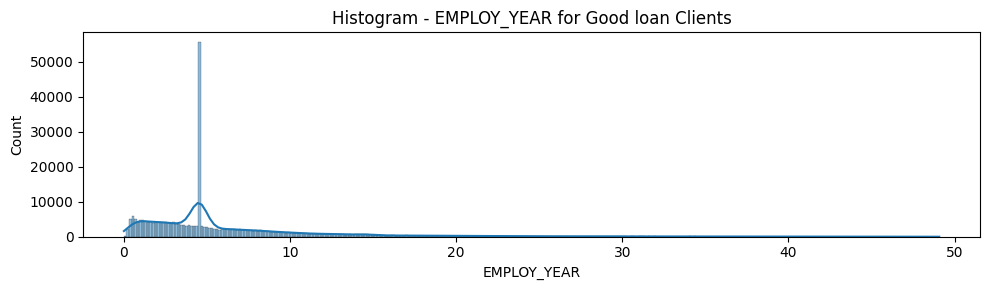

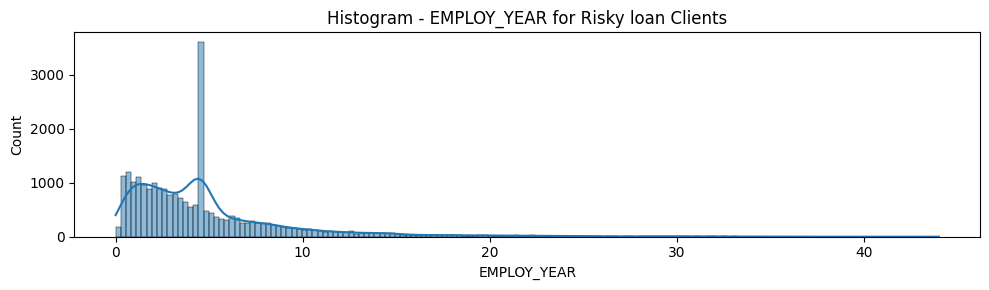

P-value: 0.0
There is a statistically significant difference between the groups.
The difference between groups in EMPLOY_YEAR mean: 1.36
Good loans:
95.0% Confidence Interval for EMPLOY_YEAR mean: [6.26, 6.30]
Risky loans:
95.0% Confidence Interval for EMPLOY_YEAR mean: [4.86, 4.98]


<IPython.core.display.Javascript object>

In [36]:
myfunctions.data_normality_check(application_train, "EMPLOY_YEAR")
myfunctions.plot_hist(df_target_0, "EMPLOY_YEAR", "Good loan")
myfunctions.plot_hist(df_target_1, "EMPLOY_YEAR", "Risky loan")
myfunctions.statistical_significance(
    df_target_0["EMPLOY_YEAR"], df_target_1["EMPLOY_YEAR"]
)
myfunctions.mean_difference(df_target_0["EMPLOY_YEAR"], df_target_1["EMPLOY_YEAR"])
print("Good loans:")
myfunctions.confidence_interval(df_target_0, "EMPLOY_YEAR")
print("Risky loans:")
myfunctions.confidence_interval(df_target_1, "EMPLOY_YEAR")

## Feature Selection

In [13]:
from IPython.display import Audio
sound_file = "button-13.wav"

<IPython.core.display.Javascript object>

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    accuracy_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import re
from sklearn import set_config
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

set_config(transform_output="pandas")
print("Setup complete")

Setup complete


<IPython.core.display.Javascript object>

In [13]:
app_train = pd.read_csv("application_train.csv")
print(app_train.shape)
app_train = app_train.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

<IPython.core.display.Javascript object>

In [14]:
X = app_train.drop(labels=["SK_ID_CURR", "TARGET"], axis=1)
y = app_train["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((246008, 120), (61503, 120), (246008,), (61503,))

<IPython.core.display.Javascript object>

In [15]:
# dropping missing values > 50% threshold and changing unknown gender, employment days annomaly to NaN:
drop_missing = Pipeline(
    steps=[
        ("change_dtypes", FunctionTransformer(myfunctions.reduce_mem_usage)),
        ("drop_most_missing", FunctionTransformer(myfunctions.delete_missing_values)),
        ("change_XNAgender", FunctionTransformer(myfunctions.delete_gender)),
        ("change_empdate", FunctionTransformer(myfunctions.replace_employ_annomaly)),
    ]
)

drop_missing.fit(X_train)
X_train = drop_missing.transform(X_train)
X_test = drop_missing.transform(X_test)

<IPython.core.display.Javascript object>

In [16]:
# replace outliers with lower/upper bound:
outlier_replace = ColumnTransformer(
    transformers=[
        (
            "replace_outliers",
            FunctionTransformer(myfunctions.replace_outliers_with_iqr),
            num_features,
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# imputation of missing values:
numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scale", StandardScaler())]
)
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)

# numeric-categorical feature split:
num_features = [
    col
    for col in X_train.select_dtypes(
        include=["float16", "float32", "float64", "int16", "int32", "int8", "int64"]
    ).columns
]
cat_features = [col for col in X_train.select_dtypes(include=["object"]).columns]


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# combine outlier replacement and imputation:
pipeline_imputer = Pipeline(
    steps=[("outliers", outlier_replace), ("preprocess", preprocessor)]
)


pipeline_imputer.fit(X_train)
X_train = pipeline_imputer.transform(X_train)
X_test = pipeline_imputer.transform(X_test)

<IPython.core.display.Javascript object>

In [17]:
# Adding features:
feature_pipeline = Pipeline(
    steps=[
        ("create_age", FunctionTransformer(myfunctions.make_age)),
        ("create_employ", FunctionTransformer(myfunctions.make_employ)),
        ("create_famincome", FunctionTransformer(myfunctions.create_income_family)),
        ("create_term", FunctionTransformer(myfunctions.create_credit_term)),
    ]
)
feature_pipeline.fit(X_train)
X_train = feature_pipeline.transform(X_train)
X_test = feature_pipeline.transform(X_test)

<IPython.core.display.Javascript object>

In [18]:
# encoding categorical values:

num_features = [
    col
    for col in X_train.select_dtypes(
        include=["float16", "float32", "float64", "int16", "int32", "int8", "int64"]
    ).columns
]
cat_features = [col for col in X_train.select_dtypes(include=["object"]).columns]


encode_transformer = Pipeline(
    [("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]
)

preprocessor = ColumnTransformer(
    transformers=[("encode", encode_transformer, cat_features)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

encode_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

X_train = encode_pipeline.fit_transform(X_train)
X_test = encode_pipeline.transform(X_test)

<IPython.core.display.Javascript object>

In [19]:
# replacing special chatacters and running first initial model for feature selection

X_train = X_train.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))
X_test = X_test.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))

model = LGBMClassifier(n_jobs=-1, class_weight="balanced", use_missing=False)
final_pipe = Pipeline(steps=[("model", model)])


final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5099
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 185
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


<IPython.core.display.Javascript object>

Probability:  [0.34791324 0.36499353 0.79883186 ... 0.31823404 0.69227201 0.61692806]
ROC_AUC score:  0.7558027669508129


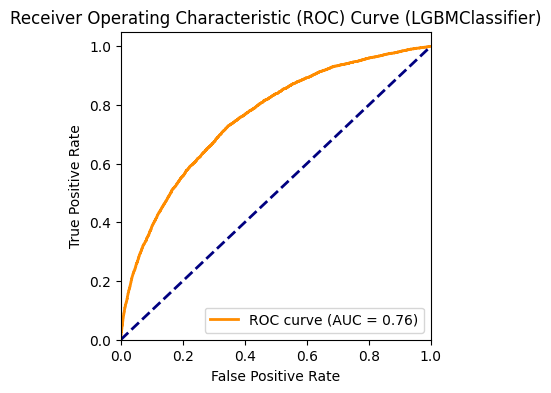

<IPython.core.display.Javascript object>

In [20]:
y_pred_prob = final_pipe.predict_proba(X_test)[:, 1]
print("Probability: ", y_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC score: ", roc_auc)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve (LGBMClassifier)")
plt.legend(loc="lower right")
plt.show()

<Figure size 800x800 with 0 Axes>

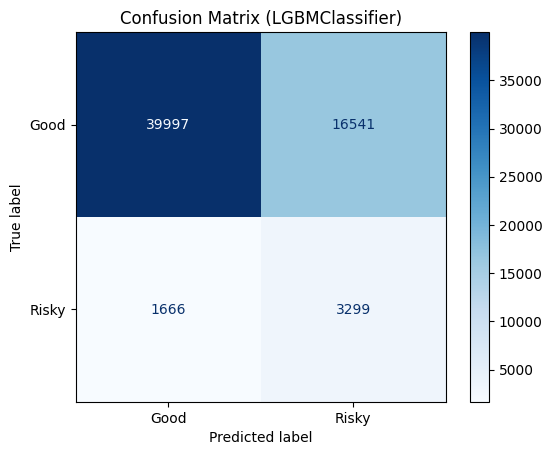

Classification report (LGBMClassifier):
---------------------------
               precision    recall  f1-score   support

        Good       0.96      0.71      0.81     56538
       Risky       0.17      0.66      0.27      4965

    accuracy                           0.70     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503



<IPython.core.display.Javascript object>

In [21]:
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=["Good", "Risky"])
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_pipe.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.xticks(np.arange(2), ["Good", "Risky"])
plt.yticks(np.arange(2), ["Good", "Risky"])
plt.title("Confusion Matrix (LGBMClassifier)")
plt.show()
print("Classification report (LGBMClassifier):\n---------------------------\n", clr)

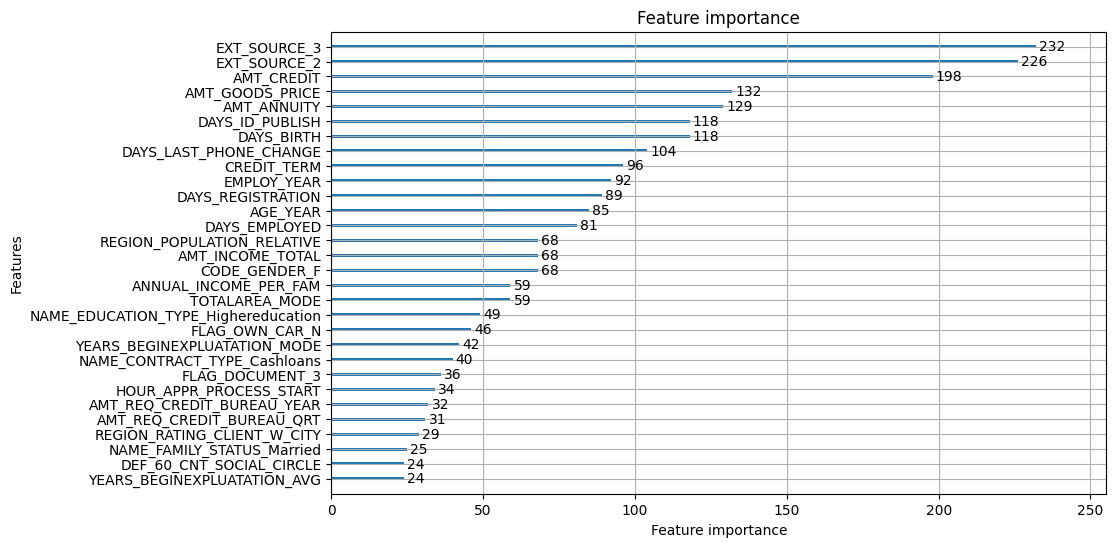

<IPython.core.display.Javascript object>

In [22]:
model_lgb = final_pipe.named_steps["model"]
lgb.plot_importance(model_lgb, figsize=(10, 6), max_num_features=30)
plt.show()

In [23]:
# filtering selected features and writing file with only selected features:
feature_imp = pd.DataFrame(
    sorted(zip(model_lgb.feature_importances_, X_train.columns)),
    columns=["Value", "Feature"],
)
features_df = feature_imp.sort_values(by="Value", ascending=False)
selected_features = list(features_df[features_df["Value"] >= 50]["Feature"])
selected_features

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'DAYS_ID_PUBLISH',
 'DAYS_BIRTH',
 'DAYS_LAST_PHONE_CHANGE',
 'CREDIT_TERM',
 'EMPLOY_YEAR',
 'DAYS_REGISTRATION',
 'AGE_YEAR',
 'DAYS_EMPLOYED',
 'REGION_POPULATION_RELATIVE',
 'CODE_GENDER_F',
 'AMT_INCOME_TOTAL',
 'TOTALAREA_MODE',
 'ANNUAL_INCOME_PER_FAM']

<IPython.core.display.Javascript object>

In [68]:
final_pipe_rf = Pipeline(
    steps=[("model", RandomForestClassifier(n_jobs=-1, class_weight="balanced"))]
)
final_pipe_rf.fit(X_train, y_train)
y_pred_rf = final_pipe_rf.predict(X_test)
report_rf = classification_report(y_test, y_pred_rf)

print("Classification Report:\n", report_rf)
y_pred_prob_rf = final_pipe_rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob_rf)
print(roc_auc)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.50      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.71      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503

0.7175942820515478


<IPython.core.display.Javascript object>

In [69]:
final_pipe_xgb = Pipeline(steps=[("model", XGBClassifier(n_jobs=-1))])
final_pipe_xgb.fit(X_train, y_train)
y_pred_xgb = final_pipe_xgb.predict(X_test)
report = classification_report(y_test, y_pred_xgb)
print("Classification Report:\n", report)
y_pred_prob_xgb = final_pipe_xgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob_xgb)
print(roc_auc)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.48      0.03      0.05      4965

    accuracy                           0.92     61503
   macro avg       0.70      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503

0.7470035125428032


<IPython.core.display.Javascript object>

In [70]:
final_pipe_log = Pipeline(
    steps=[("model", LogisticRegression(n_jobs=-1, class_weight="balanced"))]
)
final_pipe_log.fit(X_train, y_train)
y_pred_log = final_pipe_log.predict(X_test)
report = classification_report(y_test, y_pred_log)
print("Classification Report:\n", report)
y_pred_prob_log = final_pipe_log.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob_log)
print(roc_auc)

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.68      0.80     56538
           1       0.16      0.67      0.26      4965

    accuracy                           0.68     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.89      0.68      0.75     61503

0.7427388692797655


<IPython.core.display.Javascript object>

In [4]:
# this part for creating separate application_train_selected_features file with slected features:
app_train_copy = pd.read_csv("application_train.csv")
app_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


<IPython.core.display.Javascript object>

In [7]:
# dropping missing values > 50% threshold and changing unknown gender, employment days annomaly to NaN:
drop_missing_copy = Pipeline(
    steps=[
        ("change_dtypes", FunctionTransformer(myfunctions.reduce_mem_usage)),
        ("drop_most_missing", FunctionTransformer(myfunctions.delete_missing_values)),
        ("change_XNAgender", FunctionTransformer(myfunctions.delete_gender)),
        ("change_empdate", FunctionTransformer(myfunctions.replace_employ_annomaly)),
    ]
)

app_train_copy = drop_missing_copy.fit_transform(app_train_copy)

<IPython.core.display.Javascript object>

In [8]:
app_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307511 non-null  int32  
 1   TARGET                        307511 non-null  int8   
 2   NAME_CONTRACT_TYPE            307511 non-null  object 
 3   CODE_GENDER                   307507 non-null  object 
 4   FLAG_OWN_CAR                  307511 non-null  object 
 5   FLAG_OWN_REALTY               307511 non-null  object 
 6   CNT_CHILDREN                  307511 non-null  int8   
 7   AMT_INCOME_TOTAL              307511 non-null  float32
 8   AMT_CREDIT                    307511 non-null  float32
 9   AMT_ANNUITY                   307499 non-null  float32
 10  AMT_GOODS_PRICE               307233 non-null  float32
 11  NAME_TYPE_SUITE               306219 non-null  object 
 12  NAME_INCOME_TYPE              307511 non-nul

<IPython.core.display.Javascript object>

In [9]:
excluded_columns = ['SK_ID_CURR','TARGET']
num_features = [col for col in app_train_copy.select_dtypes(exclude=["object"]).columns if col not in excluded_columns]
cat_features = [col for col in app_train_copy.select_dtypes(include=["object"]).columns]

# numeric/categorical imputation:
numerical_transformer_copy = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)
categorical_transformer_copy = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)

prep_features_copy = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer_copy, num_features),
        ("cat", categorical_transformer_copy, cat_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
# outlier replacement:
outlier_replace_copy = ColumnTransformer(
    transformers=[
        (
            "replace_outliers",
            FunctionTransformer(myfunctions.replace_outliers_with_iqr),
            num_features,
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)


# provide imputation:
pipeline_imputer_copy = Pipeline(
    steps=[
        ("outliers", outlier_replace_copy),
        ("preprocess", prep_features_copy),
    ]
)
app_train_copy = pipeline_imputer_copy.fit_transform(app_train_copy)

<IPython.core.display.Javascript object>

In [10]:
app_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   CNT_CHILDREN                  307511 non-null  float64
 1   AMT_INCOME_TOTAL              307511 non-null  float64
 2   AMT_CREDIT                    307511 non-null  float64
 3   AMT_ANNUITY                   307511 non-null  float64
 4   AMT_GOODS_PRICE               307511 non-null  float64
 5   REGION_POPULATION_RELATIVE    307511 non-null  float64
 6   DAYS_BIRTH                    307511 non-null  float64
 7   DAYS_EMPLOYED                 307511 non-null  float64
 8   DAYS_REGISTRATION             307511 non-null  float64
 9   DAYS_ID_PUBLISH               307511 non-null  float64
 10  FLAG_MOBIL                    307511 non-null  float64
 11  FLAG_EMP_PHONE                307511 non-null  float64
 12  FLAG_WORK_PHONE               307511 non-nul

<IPython.core.display.Javascript object>

In [11]:
# Define a pipeline to create new features
feature_pipeline_copy = Pipeline(
    [
        ("create_age", FunctionTransformer(myfunctions.make_age)),
        ("create_employ", FunctionTransformer(myfunctions.make_employ)),
        ("create_famincome", FunctionTransformer(myfunctions.create_income_family)),
        ("create_term", FunctionTransformer(myfunctions.create_credit_term)),
    ]
)
excluded_columns = ['SK_ID_CURR','TARGET']
num_features = [col for col in app_train_copy.select_dtypes(exclude=["object"]).columns if col not in excluded_columns]
cat_features = [col for col in app_train_copy.select_dtypes(include=["object"]).columns]

# encode categorical features:
encode_transformer_copy = Pipeline(
    [("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]
)

encode_transformer = ColumnTransformer(
    transformers=[("encode", encode_transformer_copy, cat_features)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

encode_pipeline_final = Pipeline(
    steps=[("feature_create", feature_pipeline_copy), ("encode", encode_transformer)]
)

app_train_copy = encode_pipeline_final.fit_transform(app_train_copy)

<IPython.core.display.Javascript object>

In [12]:
app_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 199 entries, NAME_CONTRACT_TYPE_Cash loans to CREDIT_TERM
dtypes: float64(195), int32(1), int8(1), object(2)
memory usage: 463.7+ MB


<IPython.core.display.Javascript object>

In [24]:
# making csv file:
application_selected = app_train_copy[["SK_ID_CURR", "TARGET"] + selected_features]
application_selected.to_csv(
    "application_train_selected_features.csv",
    index=False,
    quoting=QUOTE_NONNUMERIC,
    quotechar='"',
)

<IPython.core.display.Javascript object>